James Caldwell <br>
UVA IRA <br>
5/7/24

This notebook analyzes the impact of course-taking order on student outcomes (e.g., GPA) at the University of Virginia. It was created in response to a question about whether students perform differently depending on the sequence in which they take certain key classes—e.g., is it better to take Calculus before Linear Algebra, or the other way around?

The code is a query-style script with plans to integrate into UVA's UBI (university business intelligence). The user inputs a list of courses to analyze, and the script outputs a violin plot which visualizes how students have historically performed in those courses with respect to the order that a course is taken.

In the violin plot, each course is followed by a number (1, 2, or 3 for example). The number corresponds to the order in the sequence in which the student took a course. If a student has two courses with the same number, that means they took those courses in the same semester.

In [2]:
# To do:
# deal with withdraws
# Add notes about how 1 and 1 means simultaneous
# Error check if course_df is empty
# How is APMA 3140 only have 4 students?
          # https://engineering.virginia.edu/sites/default/files/_common/departments-programs/mae/ME_Curriculum_2024.pdf
# Add error check if no students took all courses in the list
# Add second plot to show without withdraws, and add withdraw count onto plot

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
def create_violin_plot(plot_data):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(
        y='Course|Order w/ Count',
        x='Avg Grade',
        data=plot_data,
        cut=0,
        ax=ax
    )
    ax.set_ylabel("Course Order")
    ax.set_xlabel("Avg Grade of Courses")
    ax.set_title("Distributions of Grade by Class Order")
    ax.set_xlim(0, 4)  # Optional: clip to specific grade range
    return fig

In [ ]:
# has_duplicate_course
    # Called by analyze_course_order
    # This function is used if include_repeats = False
    # This function checks if there are duplicate courses in the course list string 
    # It will cause a row that has entries like "BIOL 3000 1, BIOL 3000 1" to be dropped (i.e. a student re-took a course)
def has_duplicate_course(course_list_str):
    try:
        course_list = ast.literal_eval(course_list_str)  # safely parse the string to a list
        courses_only = [c.rsplit(' ', 1)[0] for c in course_list]  # split off order number
        return len(set(courses_only)) < len(courses_only)  # True if duplicates exist
    except Exception:
        return True  # drop malformed entries

# Main function
def analyze_course_order(course_df, course_list,min_cutoff_course_number=50,include_repeats=False):
    course_df['Course'] = course_df['Subject'] + ' ' + course_df['Catalog Number'].astype(str)
    course_df.drop(columns=['Subject', 'Catalog Number','Term Desc'], inplace=True)

    # Filter data to students who took these courses
    course_df.query('Course in @course_list', inplace=True)
    # course_df

    # Add error here to check if course_df is empty.

    # How many of each course was taken, regardless of if a student took all of them or not
    course_counts_initial = course_df['Course'].value_counts()

    course_df.sort_values(by=['Student System ID', 'Term'], inplace=True)
    # Add a column for the order of the course taken by each student
    course_df['Order'] = course_df.groupby('Student System ID')['Term'].rank(method='min').astype(int)
    # course_df

    # Replace grades with scale
    replace_map = {
        'A': 4.0,
        'A-': 3.7,
        'B+': 3.3,
        'B': 3.0,
        'B-': 2.7,
        'C+': 2.3,
        'C': 2.0,
        'C-': 1.7,
        'D+': 1.3,
        'D': 1.0,
        'D-': 0.7,
        'F': 0.0,
        'W': 0.0 }# Revisit withdraws at a later time
    course_df['Official Grade'] = course_df['Official Grade'].map(replace_map)

    # Combine 3 columns into 1
    course_df['Course|Order|Grade'] = course_df['Course'] + ' ' + course_df['Order'].astype(str) + ' ' + course_df['Official Grade'].astype(str)
    # course_df

    # Drope unnecessary columns
    keep_cols = ['Student System ID', 'Course|Order|Grade']
    course_df = course_df[keep_cols].copy()

    # Group courses by student, so each student has one row and Course|Order|Grade is a list of all courses taken by that student
    course_grouped = course_df.groupby('Student System ID')['Course|Order|Grade'].apply(list).reset_index()

    # Filter to students who took all courses in course_list
    query = course_grouped[
        course_grouped['Course|Order|Grade'].apply(
            lambda course_list_full: set(course_list).issubset(
                set(' '.join(item.split()[:2]) for item in course_list_full)
            )
        )
    ]

    # Create a new column with just the course and order without grade
    query = query.copy() # Make an explicit copy to avoid modifying the original / avoid copy warnings
    query.loc[:, 'Course|Order'] = query['Course|Order|Grade'].apply(
        lambda x: [' '.join(item.split()[:3]) for item in x]
    )

    # Create a new column with just the grades. It takes an average of the grades for each courses taken by the student from the list
        # If two courses are in the course search list, Avg Grade will be the mean of those two grades
    query.loc[:, 'Avg Grade'] = query['Course|Order|Grade'].apply(
        lambda x: sum([float(item.split()[3])/len(x) for item in x])  # Extract and add the grade values (the fourth element)
    )

    # Convert to string for grouping
    query['Course|Order'] = query['Course|Order'].astype(str)

    # Filter: Keep only rows where there are NO duplicates
        # It will cause a row that has entries like "BIOL 3000 1, BIOL 3000 1" to be dropped (i.e. a student re-took a course)
    if not include_repeats:
        query = query[~query['Course|Order'].apply(has_duplicate_course)].copy()

    min_cases = min_cutoff_course_number

    # Filter out courses with fewer than min_cases occurrences
    # Also calculate how many cases each instance has to display on the violin plot
    course_counts = query['Course|Order'].value_counts()
    valid_courses = course_counts[course_counts > min_cases].index
    plot_data = query[query['Course|Order'].isin(valid_courses)].copy()
    plot_data['Course|Order w/ Count'] = plot_data['Course|Order'].apply(
        lambda x: f"{x} (n={course_counts[x]})"
    )
    
    # Create and save plot
    make_python_figure = 1 # Turn on when running in vscode. If being run automatically by qlik, keep off.
    if make_python_figure:
        fig = create_violin_plot(plot_data)
        fig.savefig("violin.png", bbox_inches='tight')

    # Calculate the above plot in table form with count and average grades for course order
    agg_result = query.groupby('Course|Order').agg({'Avg Grade': ['count', 'mean']})
    agg_result.columns = ['Count', 'Average Grade']
    agg_result = agg_result.sort_values(by=('Average Grade'),  ascending=False)
    agg_result.sort_values(by=('Count'),  ascending=False, inplace=True)

    agg_result.reset_index(inplace=True)
    return course_counts_initial, agg_result, plot_data,query

False
yay


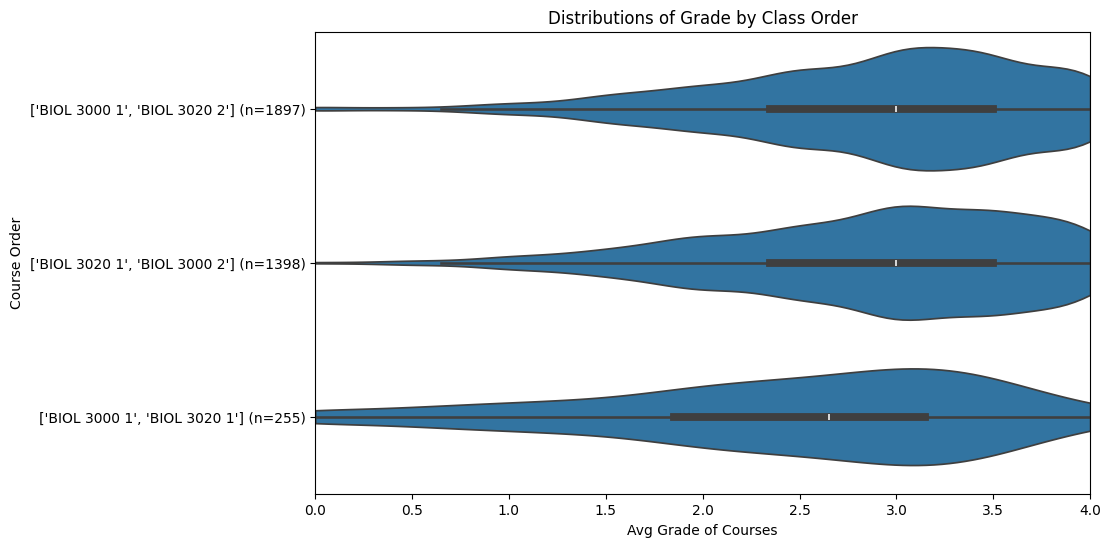

In [119]:
# import data
courses_data = pd.read_parquet('Course_Grade_Data.parquet')
qlik_user_input = pd.read_csv('UserParameters_qlik_user_output.csv')

# Collect course list (eg ['BIOL 3000', 'BIOL 3020'], min cutoff course number, and whether to include repeats)
course_list = qlik_user_input['SelectedCourses'].fillna('').str.strip().tolist()
course_list = [c for c in course_list if str(c).strip()] # Make list empty if filled with "Missing value"
min_cutoff_course_number =  qlik_user_input['CutoffInput'].iloc[0]
include_repeats =  qlik_user_input['RepeatYesNo'].iloc[0]

try:
    min_cutoff_course_number = int(min_cutoff_course_number)
except:
    min_cutoff_course_number = 50 # Default to 50 if missing value or non integer input

if str(include_repeats).strip().lower() == 'yes':
    include_repeats = True
else:
    include_repeats = False # Default is exclude repeats/failed and re-taken courses

if len(course_list) < 2:
    error_message = 'Error: Please select at least two courses'
else:
    try:
        [course_counts, agg_result, plot_data, query] = analyze_course_order(courses_data, course_list,min_cutoff_course_number,include_repeats)
        # course_counts # Course counts is the number of students who have taken either course. 
        plot_data_cols_to_keep = ['Student System ID', 'Avg Grade','Course|Order w/ Count']
        with pd.ExcelWriter('python_output.xlsx', engine='openpyxl') as writer:
            plot_data[plot_data_cols_to_keep].to_excel(writer, sheet_name='Plot Data', index=False)
            agg_result.to_excel(writer, sheet_name='Summary Table', index=False)
        error_message = 'No errors'
    except:
        error_message = 'Error: Please check that all inputs are valid'

In [111]:
query['Course|Order'].iloc[0]

"['BIOL 3000 1', 'BIOL 3020 2']"

In [ ]:
import ast  # safely evaluate string lists

query_test = query.copy()


# Filter: Keep only rows where there are NO duplicates
query_clean = query_test[~query_test['Course|Order'].apply(has_duplicate_course)].copy()


In [ ]:
# This removes the extra order numbers. But then you can't tell when there were simultaneous courses. Keeping here in case it's useful. 
# import ast
# # ast converts string to list
# agg_result['Course|Order'] = agg_result['Course|Order'].apply(
#     lambda s: [' '.join(item.split()[:2]) for item in ast.literal_eval(s)]
# )

